In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
%matplotlib inline
import os

In [2]:
img_size=64
b_size=128
nz=150
nfilters=128
device=torch.device('cuda')

In [3]:
dataset=torchvision.datasets.ImageFolder(
    root=r'D:\study\python\Project\gan\anime faces',
    transform=transforms.Compose([
        transforms.ToTensor(),
    ])
)


In [4]:
dataloader=torch.utils.data.DataLoader(dataset,
    batch_size=b_size,shuffle=False,num_workers=6)

In [68]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [69]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main=torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels=nz,
                out_channels=nfilters*8,
                kernel_size=4,stride=1,padding=0,
            ),
            torch.nn.BatchNorm2d(nfilters*8),
            torch.nn.ReLU(True),#out=(N,8*128,4,4)
            
            torch.nn.ConvTranspose2d(
                in_channels=nfilters*8,
                out_channels=nfilters*6,
                kernel_size=4,stride=4,padding=2
            ),
            torch.nn.BatchNorm2d(nfilters*6),
            torch.nn.ReLU(True),#out=(N,6*128,12,12)
            
            torch.nn.ConvTranspose2d(
                in_channels=nfilters*6,
                out_channels=nfilters*4,
                kernel_size=4,stride=2,padding=1
            ),
            torch.nn.BatchNorm2d(nfilters*4),
            torch.nn.ReLU(True),#out=(N,4*128,24,24)
            
            torch.nn.ConvTranspose2d(
                in_channels=nfilters*4,
                out_channels=nfilters*2,
                kernel_size=4,stride=2,padding=1
            ),
            torch.nn.BatchNorm2d(nfilters*2),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(
                in_channels=nfilters*2,
                out_channels=3,
                kernel_size=4,stride=2,padding=1
            ),#out=(N,1*128,96,96)
            torch.nn.Tanh(),
        )
    def forward(self,input):
        return self.main(input)
    


In [70]:
#令出negG
netG=Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(150, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(1024, 768, kernel_size=(4, 4), stride=(4, 4), padding=(2, 2))
    (4): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(768, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(256, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)


In [56]:
next(netG.parameters()).is_cuda

True

In [71]:
def norm01(input):
    mx=np.max(input)
    mn=np.min(input)
    return (input-mn)/(mx-mn)

In [72]:
#netG
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.main=nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=nfilters,
                      kernel_size=4,
                      stride=2,
                      padding=1),
            nn.LeakyReLU(0.2, inplace=True),#(n,48,48)
            
            nn.Conv2d(in_channels=nfilters,
            out_channels=nfilters*2,
            kernel_size=4,
            stride=2,
            padding=1),
            nn.BatchNorm2d(nfilters*2),
            nn.LeakyReLU(0.2, inplace=True),#(n,24,24)
            
            nn.Conv2d(in_channels=nfilters*2,
            out_channels=nfilters*4,
            kernel_size=4,
            stride=2,
            padding=1),
            nn.BatchNorm2d(nfilters*4),
            nn.LeakyReLU(0.2, inplace=True),#(n,12,12)
            
            
            nn.Conv2d(in_channels=nfilters*4,
            out_channels=nfilters*8,
            kernel_size=4,
            stride=4,
            padding=2),
            nn.BatchNorm2d(nfilters*8),
            nn.LeakyReLU(0.2, inplace=True),#(n,4,4)
            
            nn.Conv2d(in_channels=nfilters*8,
                      out_channels=1,
                      kernel_size=4,
                      padding=0,
                      stride=1),
            nn.Sigmoid(),
        )
    def forward(self,input):
        return self.main(input)


In [73]:
#构建netD
netD=Discriminator().to(device)
netD.apply(weights_init)
print(netD)
next(netD.parameters()).is_cuda



Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(4, 4), padding=(2, 2))
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)


True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


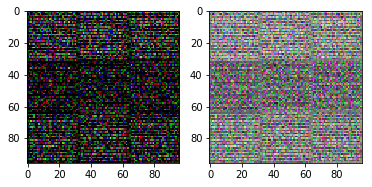

In [74]:
#输出并检查图像
z=torch.randn(1,nz,1,1).to(device)
with torch.no_grad():
    out=netG(z)
    out2=netG.forward(z)
    
# if(out.view(96,96,3).cpu().numpy().all()
#         ==out2.view(96,96,3).cpu().numpy().all):
#     print('yes')
# 
# print(out[0],out2[0])

out_im=out.view(96,96,3).cpu().numpy()
out_im_n=norm01(out_im)

plt.figure()
plt.subplot(121)
plt.imshow(out_im)
plt.subplot(122)
plt.imshow(out_im_n)

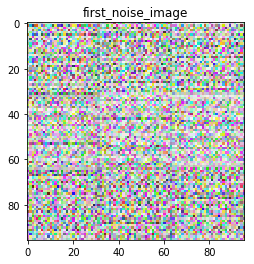

In [81]:
#定义损失函数，优化函数
loss_fn=nn.BCELoss()

opt_g=torch.optim.Adam(netG.parameters(),lr=4e-4,
                       betas=(0.5,0.99))
opt_d=torch.optim.Adam(netD.parameters(),lr=1e-4,
                       betas=(0.5,0.99))
#用一个固定的噪音，来追踪训练过程中的图像变化
fixed_noise=z
with torch.no_grad():
    out=netG.forward(fixed_noise)
out_img=out.view(96,96,3).cpu().numpy()
out_img_n=norm01(out_img)
plt.figure()
plt.title('first_noise_image')
plt.imshow(out_img_n)


In [77]:
#开始训练。首先用三个list储存训练过程的数据
img_list=[]
G_losses=[]
D_losses=[]
print(img_list)

[]


In [82]:
for t in range(5):#训练5个epoch
    for step,data in enumerate(dataloader):
        data_img=data[0].to(device)
        batch_size=data_img.size()[0]
        #先训练netD
        netD.zero_grad()
        labels_true=torch.full((batch_size,),1
                               ,device=device)
        labels_false=torch.full((batch_size,),0
                               ,device=device)
        # with torch.no_grad():
        out_batch=netD(data_img).view(batch_size,)
        D_true=out_batch.mean().item()
        loss_D1=loss_fn(out_batch,labels_true)
        
        loss_D1.backward()
        
        r_data=torch.randn(batch_size,nz,1,1,
                           device=device)
        # with torch.no_grad():
        out_mid=netG(r_data)
        out_batch=netD(out_mid.detach()).view(-1)
        D_G1=out_batch.mean().item()
        
        loss_D2=loss_fn(out_batch,labels_false)

        loss_D=loss_D1+loss_D2
        loss_D2.backward()
        
        opt_d.step()
        
        
        #再训练netG
        netG.zero_grad()
        # with torch.no_grad():
        out_batch=netD(out_mid).view(-1)
        loss_G=loss_fn(out_batch,labels_true)
        loss_G.backward()
        opt_g.step()
        D_G2=out_batch.mean().item()
        #存储
        
        if(step%10==0):
            print('[%d/%d][%d/%d]\tLoss_D=%.4f\tLoss_G=%.4f\tD(x)=%.4f\tD(g1)/D(g2)=%.4f/%.4f'%(t+1,5,step,len(dataloader),loss_D.item()
                                                                                                ,loss_G.item(),D_true
                                                                                                ,D_G1,D_G2))
            # print(labels_true)
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        
        if(step%100==0):
            with torch.no_grad():
                temp_out=netG.forward(fixed_noise).detach().view(96,96,3).cpu()
            img_list.append(temp_out.numpy())
        

[1/5][0/401]	Loss_D=0.0005	Loss_G=30.8175	D(x)=0.9995	D(g1)/D(g2)=0.0000/0.0000


[1/5][10/401]	Loss_D=4.9861	Loss_G=15.0444	D(x)=0.3997	D(g1)/D(g2)=0.5131/0.0001


[1/5][20/401]	Loss_D=5.8339	Loss_G=2.1287	D(x)=0.1457	D(g1)/D(g2)=0.4967/0.3726


[1/5][30/401]	Loss_D=3.3431	Loss_G=1.5727	D(x)=0.1946	D(g1)/D(g2)=0.3562/0.3600


[1/5][40/401]	Loss_D=2.7326	Loss_G=0.8003	D(x)=0.2267	D(g1)/D(g2)=0.4300/0.5206


[1/5][50/401]	Loss_D=3.1233	Loss_G=1.7673	D(x)=0.2601	D(g1)/D(g2)=0.5498/0.2181


[1/5][60/401]	Loss_D=2.4446	Loss_G=0.8106	D(x)=0.2341	D(g1)/D(g2)=0.3630/0.4901


[1/5][70/401]	Loss_D=2.7651	Loss_G=0.9082	D(x)=0.2043	D(g1)/D(g2)=0.3190/0.4960


[1/5][80/401]	Loss_D=3.4557	Loss_G=0.5692	D(x)=0.0969	D(g1)/D(g2)=0.3675/0.6097


[1/5][90/401]	Loss_D=2.4405	Loss_G=4.2257	D(x)=0.6366	D(g1)/D(g2)=0.7848/0.0278


[1/5][100/401]	Loss_D=2.0800	Loss_G=2.1825	D(x)=0.5988	D(g1)/D(g2)=0.6633/0.1681


[1/5][110/401]	Loss_D=2.7355	Loss_G=3.9471	D(x)=0.6525	D(g1)/D(g2)=0.8724/0.0279


[1/5][120/401]	Loss_D=1.1452	Loss_G=2.1904	D(x)=0.6255	D(g1)/D(g2)=0.4130/0.1330


[1/5][130/401]	Loss_D=1.6636	Loss_G=3.3379	D(x)=0.6931	D(g1)/D(g2)=0.6574/0.0484


[1/5][140/401]	Loss_D=1.1026	Loss_G=2.4575	D(x)=0.5977	D(g1)/D(g2)=0.3278/0.1185


[1/5][150/401]	Loss_D=1.0254	Loss_G=3.3384	D(x)=0.7486	D(g1)/D(g2)=0.4589/0.0493


[1/5][160/401]	Loss_D=1.4575	Loss_G=3.5144	D(x)=0.6673	D(g1)/D(g2)=0.4914/0.0560


[1/5][170/401]	Loss_D=1.5380	Loss_G=1.5578	D(x)=0.4012	D(g1)/D(g2)=0.1749/0.3231


[1/5][180/401]	Loss_D=2.1723	Loss_G=2.3170	D(x)=0.6216	D(g1)/D(g2)=0.7162/0.1531


[1/5][190/401]	Loss_D=1.7188	Loss_G=1.3469	D(x)=0.4914	D(g1)/D(g2)=0.4700/0.3316


[1/5][200/401]	Loss_D=2.0876	Loss_G=1.5712	D(x)=0.4675	D(g1)/D(g2)=0.6358/0.2481


[1/5][210/401]	Loss_D=1.9506	Loss_G=0.7828	D(x)=0.2880	D(g1)/D(g2)=0.2996/0.5120


[1/5][220/401]	Loss_D=1.6589	Loss_G=1.2391	D(x)=0.4113	D(g1)/D(g2)=0.4253/0.3340


[1/5][230/401]	Loss_D=1.8476	Loss_G=1.1200	D(x)=0.4686	D(g1)/D(g2)=0.5792/0.3678


[1/5][240/401]	Loss_D=2.0579	Loss_G=1.5079	D(x)=0.4685	D(g1)/D(g2)=0.6248/0.2649


[1/5][250/401]	Loss_D=1.7376	Loss_G=1.4868	D(x)=0.5270	D(g1)/D(g2)=0.5566/0.2752


[1/5][260/401]	Loss_D=1.5731	Loss_G=1.2324	D(x)=0.5050	D(g1)/D(g2)=0.4847/0.3430


[1/5][270/401]	Loss_D=1.8310	Loss_G=0.8746	D(x)=0.3604	D(g1)/D(g2)=0.4261/0.4604


[1/5][280/401]	Loss_D=1.5607	Loss_G=1.1108	D(x)=0.4541	D(g1)/D(g2)=0.4116/0.3984


[1/5][290/401]	Loss_D=1.3478	Loss_G=1.5596	D(x)=0.5941	D(g1)/D(g2)=0.4999/0.2425


[1/5][300/401]	Loss_D=1.6487	Loss_G=1.1219	D(x)=0.4217	D(g1)/D(g2)=0.4483/0.3573


[1/5][310/401]	Loss_D=1.6050	Loss_G=0.9836	D(x)=0.4278	D(g1)/D(g2)=0.4540/0.4027


[1/5][320/401]	Loss_D=1.5124	Loss_G=1.5171	D(x)=0.5071	D(g1)/D(g2)=0.4916/0.2440


[1/5][330/401]	Loss_D=1.4632	Loss_G=1.3995	D(x)=0.5138	D(g1)/D(g2)=0.4693/0.2864


[1/5][340/401]	Loss_D=1.4707	Loss_G=0.9465	D(x)=0.4571	D(g1)/D(g2)=0.3879/0.4288


[1/5][350/401]	Loss_D=1.4873	Loss_G=0.9557	D(x)=0.4239	D(g1)/D(g2)=0.3986/0.4182


[1/5][360/401]	Loss_D=1.9494	Loss_G=0.7352	D(x)=0.3165	D(g1)/D(g2)=0.4400/0.5110


[1/5][370/401]	Loss_D=1.7137	Loss_G=1.5500	D(x)=0.4893	D(g1)/D(g2)=0.5566/0.2483


[1/5][380/401]	Loss_D=1.6761	Loss_G=1.6677	D(x)=0.6598	D(g1)/D(g2)=0.6665/0.2181


[1/5][390/401]	Loss_D=1.7037	Loss_G=0.6578	D(x)=0.3244	D(g1)/D(g2)=0.3034/0.5496


[1/5][400/401]	Loss_D=2.2122	Loss_G=0.6390	D(x)=0.1813	D(g1)/D(g2)=0.2942/0.5675


[2/5][0/401]	Loss_D=1.8410	Loss_G=2.4383	D(x)=0.7496	D(g1)/D(g2)=0.7533/0.1066


[2/5][10/401]	Loss_D=1.8376	Loss_G=1.7112	D(x)=0.5152	D(g1)/D(g2)=0.6222/0.2078


[2/5][20/401]	Loss_D=1.7290	Loss_G=0.6344	D(x)=0.3039	D(g1)/D(g2)=0.2989/0.5525


[2/5][30/401]	Loss_D=1.6228	Loss_G=1.7974	D(x)=0.7531	D(g1)/D(g2)=0.6990/0.1882


[2/5][40/401]	Loss_D=1.5821	Loss_G=1.3600	D(x)=0.4253	D(g1)/D(g2)=0.4501/0.2920


[2/5][50/401]	Loss_D=1.3969	Loss_G=1.4731	D(x)=0.5521	D(g1)/D(g2)=0.4663/0.2673


[2/5][60/401]	Loss_D=1.4636	Loss_G=1.6843	D(x)=0.7386	D(g1)/D(g2)=0.6248/0.2317


[2/5][70/401]	Loss_D=1.5641	Loss_G=0.9176	D(x)=0.3456	D(g1)/D(g2)=0.2807/0.4473


[2/5][80/401]	Loss_D=1.6653	Loss_G=1.9435	D(x)=0.6785	D(g1)/D(g2)=0.6847/0.1699


[2/5][90/401]	Loss_D=1.8595	Loss_G=0.6588	D(x)=0.2722	D(g1)/D(g2)=0.2616/0.5465


[2/5][100/401]	Loss_D=1.3920	Loss_G=1.5933	D(x)=0.5997	D(g1)/D(g2)=0.5392/0.2340


[2/5][110/401]	Loss_D=1.5224	Loss_G=2.2642	D(x)=0.6447	D(g1)/D(g2)=0.6134/0.1279


[2/5][120/401]	Loss_D=1.6020	Loss_G=0.6966	D(x)=0.3462	D(g1)/D(g2)=0.3027/0.5262


[2/5][130/401]	Loss_D=1.6339	Loss_G=1.0089	D(x)=0.4141	D(g1)/D(g2)=0.4595/0.3994


[2/5][140/401]	Loss_D=1.4542	Loss_G=1.6534	D(x)=0.5563	D(g1)/D(g2)=0.5117/0.2279


[2/5][150/401]	Loss_D=1.3466	Loss_G=1.3877	D(x)=0.4709	D(g1)/D(g2)=0.3692/0.2840


[2/5][160/401]	Loss_D=1.5110	Loss_G=1.1773	D(x)=0.4849	D(g1)/D(g2)=0.4878/0.3297


[2/5][170/401]	Loss_D=1.4888	Loss_G=1.1919	D(x)=0.4499	D(g1)/D(g2)=0.4297/0.3407


[2/5][180/401]	Loss_D=1.8372	Loss_G=1.1819	D(x)=0.4084	D(g1)/D(g2)=0.5270/0.3404


[2/5][190/401]	Loss_D=1.8567	Loss_G=0.9908	D(x)=0.3325	D(g1)/D(g2)=0.4452/0.3917


[2/5][200/401]	Loss_D=1.7156	Loss_G=1.3707	D(x)=0.5020	D(g1)/D(g2)=0.6014/0.2771


[2/5][210/401]	Loss_D=1.5788	Loss_G=1.2820	D(x)=0.4336	D(g1)/D(g2)=0.4403/0.3234


[2/5][220/401]	Loss_D=1.9648	Loss_G=1.0549	D(x)=0.3321	D(g1)/D(g2)=0.4347/0.3893


[2/5][230/401]	Loss_D=1.6158	Loss_G=1.2884	D(x)=0.5169	D(g1)/D(g2)=0.5648/0.3000


[2/5][240/401]	Loss_D=1.6484	Loss_G=0.8624	D(x)=0.3768	D(g1)/D(g2)=0.3997/0.4543


[2/5][250/401]	Loss_D=1.6865	Loss_G=0.9182	D(x)=0.3308	D(g1)/D(g2)=0.3456/0.4364


[2/5][260/401]	Loss_D=1.4558	Loss_G=1.5720	D(x)=0.5940	D(g1)/D(g2)=0.5665/0.2327


[2/5][270/401]	Loss_D=1.4600	Loss_G=1.0858	D(x)=0.4325	D(g1)/D(g2)=0.4040/0.3606


[2/5][280/401]	Loss_D=1.5077	Loss_G=1.3673	D(x)=0.4212	D(g1)/D(g2)=0.3914/0.2976


[2/5][290/401]	Loss_D=1.4327	Loss_G=1.1967	D(x)=0.4536	D(g1)/D(g2)=0.4199/0.3233


[2/5][300/401]	Loss_D=1.4326	Loss_G=1.8605	D(x)=0.6502	D(g1)/D(g2)=0.5938/0.1717


[2/5][310/401]	Loss_D=1.6311	Loss_G=1.3266	D(x)=0.4783	D(g1)/D(g2)=0.5323/0.2999


[2/5][320/401]	Loss_D=1.6804	Loss_G=1.5220	D(x)=0.5311	D(g1)/D(g2)=0.5922/0.2580


[2/5][330/401]	Loss_D=1.5033	Loss_G=0.9592	D(x)=0.3612	D(g1)/D(g2)=0.3109/0.4107


[2/5][340/401]	Loss_D=1.3458	Loss_G=1.0681	D(x)=0.4386	D(g1)/D(g2)=0.3502/0.3629


[2/5][350/401]	Loss_D=1.4097	Loss_G=1.3379	D(x)=0.4586	D(g1)/D(g2)=0.4209/0.2848


[2/5][360/401]	Loss_D=1.6223	Loss_G=0.9311	D(x)=0.3383	D(g1)/D(g2)=0.3105/0.4292


[2/5][370/401]	Loss_D=1.6527	Loss_G=1.0648	D(x)=0.3609	D(g1)/D(g2)=0.3327/0.3878


[2/5][380/401]	Loss_D=1.8450	Loss_G=2.0612	D(x)=0.5262	D(g1)/D(g2)=0.6393/0.1496


[2/5][390/401]	Loss_D=1.4090	Loss_G=1.0694	D(x)=0.4987	D(g1)/D(g2)=0.4727/0.3580


[2/5][400/401]	Loss_D=1.4840	Loss_G=1.5909	D(x)=0.6403	D(g1)/D(g2)=0.6292/0.2149


[3/5][0/401]	Loss_D=1.3326	Loss_G=1.2428	D(x)=0.4570	D(g1)/D(g2)=0.3703/0.3131


[3/5][10/401]	Loss_D=1.5429	Loss_G=1.2738	D(x)=0.4434	D(g1)/D(g2)=0.4641/0.3041


[3/5][20/401]	Loss_D=1.6552	Loss_G=1.4327	D(x)=0.5213	D(g1)/D(g2)=0.5800/0.2667


[3/5][30/401]	Loss_D=1.5776	Loss_G=1.6957	D(x)=0.4907	D(g1)/D(g2)=0.5257/0.2087


[3/5][40/401]	Loss_D=1.2254	Loss_G=1.8302	D(x)=0.6657	D(g1)/D(g2)=0.5283/0.1775


[3/5][50/401]	Loss_D=1.4866	Loss_G=1.3363	D(x)=0.4676	D(g1)/D(g2)=0.4565/0.2953


[3/5][60/401]	Loss_D=1.4374	Loss_G=0.9154	D(x)=0.4116	D(g1)/D(g2)=0.3555/0.4205


[3/5][70/401]	Loss_D=1.6505	Loss_G=1.8534	D(x)=0.6452	D(g1)/D(g2)=0.6719/0.1743


[3/5][80/401]	Loss_D=1.5879	Loss_G=1.1231	D(x)=0.4397	D(g1)/D(g2)=0.4705/0.3491


[3/5][90/401]	Loss_D=1.2985	Loss_G=1.2506	D(x)=0.4625	D(g1)/D(g2)=0.3401/0.3029


[3/5][100/401]	Loss_D=1.3830	Loss_G=1.4656	D(x)=0.4824	D(g1)/D(g2)=0.4258/0.2590


[3/5][110/401]	Loss_D=1.7564	Loss_G=1.0384	D(x)=0.3104	D(g1)/D(g2)=0.3633/0.3870


[3/5][120/401]	Loss_D=1.5685	Loss_G=1.2414	D(x)=0.4898	D(g1)/D(g2)=0.5253/0.3092


[3/5][130/401]	Loss_D=1.2853	Loss_G=1.3230	D(x)=0.4640	D(g1)/D(g2)=0.3378/0.2892


[3/5][140/401]	Loss_D=1.4038	Loss_G=1.3665	D(x)=0.5109	D(g1)/D(g2)=0.4716/0.2799


[3/5][150/401]	Loss_D=2.2068	Loss_G=2.4241	D(x)=0.6424	D(g1)/D(g2)=0.7813/0.1076


[3/5][160/401]	Loss_D=1.3688	Loss_G=1.4735	D(x)=0.5835	D(g1)/D(g2)=0.5243/0.2518


[3/5][170/401]	Loss_D=1.4457	Loss_G=1.2043	D(x)=0.5158	D(g1)/D(g2)=0.4779/0.3267


[3/5][180/401]	Loss_D=1.6245	Loss_G=1.9272	D(x)=0.5750	D(g1)/D(g2)=0.6189/0.1624


[3/5][190/401]	Loss_D=1.6892	Loss_G=1.2422	D(x)=0.4772	D(g1)/D(g2)=0.5601/0.3159


[3/5][200/401]	Loss_D=1.7652	Loss_G=1.5968	D(x)=0.5228	D(g1)/D(g2)=0.6303/0.2240


[3/5][210/401]	Loss_D=1.1069	Loss_G=1.6006	D(x)=0.5882	D(g1)/D(g2)=0.4005/0.2224


[3/5][220/401]	Loss_D=1.3012	Loss_G=0.9479	D(x)=0.4183	D(g1)/D(g2)=0.2927/0.4106


[3/5][230/401]	Loss_D=1.4322	Loss_G=1.1824	D(x)=0.4755	D(g1)/D(g2)=0.4244/0.3468


[3/5][240/401]	Loss_D=1.6192	Loss_G=1.0661	D(x)=0.3733	D(g1)/D(g2)=0.3892/0.3625


[3/5][250/401]	Loss_D=1.4199	Loss_G=1.6034	D(x)=0.5658	D(g1)/D(g2)=0.5212/0.2189


[3/5][260/401]	Loss_D=1.5540	Loss_G=1.3219	D(x)=0.4445	D(g1)/D(g2)=0.4841/0.2873


[3/5][270/401]	Loss_D=1.6952	Loss_G=1.4128	D(x)=0.4889	D(g1)/D(g2)=0.5762/0.2686


[3/5][280/401]	Loss_D=1.7356	Loss_G=1.4275	D(x)=0.4993	D(g1)/D(g2)=0.5978/0.2619


[3/5][290/401]	Loss_D=1.6011	Loss_G=1.3832	D(x)=0.5261	D(g1)/D(g2)=0.5597/0.2768


[3/5][300/401]	Loss_D=1.2996	Loss_G=1.4382	D(x)=0.5514	D(g1)/D(g2)=0.4472/0.2677


[3/5][310/401]	Loss_D=1.4689	Loss_G=1.6344	D(x)=0.5341	D(g1)/D(g2)=0.5248/0.2211


[3/5][320/401]	Loss_D=1.4134	Loss_G=1.5149	D(x)=0.5439	D(g1)/D(g2)=0.5014/0.2421


[3/5][330/401]	Loss_D=1.4008	Loss_G=1.8025	D(x)=0.6619	D(g1)/D(g2)=0.5897/0.1856


[3/5][340/401]	Loss_D=1.6135	Loss_G=1.8437	D(x)=0.5939	D(g1)/D(g2)=0.6248/0.1789


[3/5][350/401]	Loss_D=1.4316	Loss_G=1.3051	D(x)=0.4948	D(g1)/D(g2)=0.4683/0.2929


[3/5][360/401]	Loss_D=1.5456	Loss_G=0.6063	D(x)=0.2922	D(g1)/D(g2)=0.1856/0.5715


[3/5][370/401]	Loss_D=1.3587	Loss_G=1.3555	D(x)=0.5723	D(g1)/D(g2)=0.5184/0.2781


[3/5][380/401]	Loss_D=1.5361	Loss_G=1.2810	D(x)=0.4742	D(g1)/D(g2)=0.4934/0.3133


[3/5][390/401]	Loss_D=1.5460	Loss_G=0.9599	D(x)=0.4560	D(g1)/D(g2)=0.4645/0.4049


[3/5][400/401]	Loss_D=1.6483	Loss_G=0.8593	D(x)=0.4026	D(g1)/D(g2)=0.4652/0.4428


[4/5][0/401]	Loss_D=1.5728	Loss_G=1.4846	D(x)=0.6278	D(g1)/D(g2)=0.6295/0.2516


[4/5][10/401]	Loss_D=1.5096	Loss_G=1.0831	D(x)=0.5525	D(g1)/D(g2)=0.5649/0.3531


[4/5][20/401]	Loss_D=1.4513	Loss_G=0.9728	D(x)=0.4248	D(g1)/D(g2)=0.3883/0.4038


[4/5][30/401]	Loss_D=1.5497	Loss_G=1.0778	D(x)=0.5042	D(g1)/D(g2)=0.5483/0.3568


[4/5][40/401]	Loss_D=1.4865	Loss_G=0.9530	D(x)=0.3890	D(g1)/D(g2)=0.3459/0.4096


[4/5][50/401]	Loss_D=2.2641	Loss_G=0.4722	D(x)=0.1362	D(g1)/D(g2)=0.1217/0.6348


[4/5][60/401]	Loss_D=1.4977	Loss_G=1.0716	D(x)=0.4557	D(g1)/D(g2)=0.4527/0.3678


[4/5][70/401]	Loss_D=1.5593	Loss_G=1.0693	D(x)=0.5014	D(g1)/D(g2)=0.5299/0.3629


[4/5][80/401]	Loss_D=1.5781	Loss_G=1.3274	D(x)=0.5601	D(g1)/D(g2)=0.5995/0.2900


[4/5][90/401]	Loss_D=1.3873	Loss_G=1.1755	D(x)=0.5123	D(g1)/D(g2)=0.4838/0.3230


[4/5][100/401]	Loss_D=1.3777	Loss_G=1.2657	D(x)=0.5390	D(g1)/D(g2)=0.5094/0.2981


[4/5][110/401]	Loss_D=1.3674	Loss_G=1.3923	D(x)=0.5401	D(g1)/D(g2)=0.5011/0.2641


[4/5][120/401]	Loss_D=1.4773	Loss_G=1.4276	D(x)=0.5650	D(g1)/D(g2)=0.5611/0.2620


[4/5][130/401]	Loss_D=1.6331	Loss_G=1.2838	D(x)=0.5153	D(g1)/D(g2)=0.5720/0.2989


[4/5][140/401]	Loss_D=1.6976	Loss_G=1.7863	D(x)=0.6554	D(g1)/D(g2)=0.6919/0.1828


[4/5][150/401]	Loss_D=1.5819	Loss_G=1.1159	D(x)=0.4819	D(g1)/D(g2)=0.5164/0.3493


[4/5][160/401]	Loss_D=1.3723	Loss_G=1.2477	D(x)=0.5309	D(g1)/D(g2)=0.4794/0.3068


[4/5][170/401]	Loss_D=1.3394	Loss_G=1.1072	D(x)=0.4713	D(g1)/D(g2)=0.4064/0.3432


[4/5][180/401]	Loss_D=1.5032	Loss_G=0.6679	D(x)=0.3840	D(g1)/D(g2)=0.3633/0.5242


[4/5][190/401]	Loss_D=1.4035	Loss_G=1.1554	D(x)=0.4713	D(g1)/D(g2)=0.4373/0.3360


[4/5][200/401]	Loss_D=1.5190	Loss_G=1.2882	D(x)=0.5427	D(g1)/D(g2)=0.5617/0.2958


[4/5][210/401]	Loss_D=1.4528	Loss_G=1.3136	D(x)=0.4848	D(g1)/D(g2)=0.4697/0.2906


[4/5][220/401]	Loss_D=1.2898	Loss_G=0.8590	D(x)=0.4906	D(g1)/D(g2)=0.4057/0.4369


[4/5][230/401]	Loss_D=1.3658	Loss_G=1.3863	D(x)=0.5554	D(g1)/D(g2)=0.5129/0.2660


[4/5][240/401]	Loss_D=1.5166	Loss_G=1.7053	D(x)=0.6371	D(g1)/D(g2)=0.6350/0.1949


[4/5][250/401]	Loss_D=1.5993	Loss_G=0.8085	D(x)=0.3319	D(g1)/D(g2)=0.3327/0.4570


[4/5][260/401]	Loss_D=1.4422	Loss_G=1.0380	D(x)=0.4351	D(g1)/D(g2)=0.4056/0.3793


[4/5][270/401]	Loss_D=1.3423	Loss_G=0.9973	D(x)=0.4769	D(g1)/D(g2)=0.4209/0.3831


[4/5][280/401]	Loss_D=1.3709	Loss_G=1.0708	D(x)=0.4435	D(g1)/D(g2)=0.3824/0.3659


[4/5][290/401]	Loss_D=1.5265	Loss_G=1.1676	D(x)=0.5188	D(g1)/D(g2)=0.5499/0.3292


[4/5][300/401]	Loss_D=1.3527	Loss_G=1.1218	D(x)=0.5352	D(g1)/D(g2)=0.4829/0.3457


[4/5][310/401]	Loss_D=1.6026	Loss_G=0.9130	D(x)=0.4296	D(g1)/D(g2)=0.4885/0.4181


[4/5][320/401]	Loss_D=1.5671	Loss_G=0.7525	D(x)=0.3440	D(g1)/D(g2)=0.3205/0.4906


[4/5][330/401]	Loss_D=1.3955	Loss_G=0.9025	D(x)=0.3834	D(g1)/D(g2)=0.3108/0.4158


[4/5][340/401]	Loss_D=1.4971	Loss_G=0.8219	D(x)=0.3626	D(g1)/D(g2)=0.3295/0.4516


[4/5][350/401]	Loss_D=1.5386	Loss_G=1.6295	D(x)=0.5829	D(g1)/D(g2)=0.5980/0.2121


[4/5][360/401]	Loss_D=1.5168	Loss_G=0.7483	D(x)=0.3822	D(g1)/D(g2)=0.3712/0.4892


[4/5][370/401]	Loss_D=1.2067	Loss_G=1.0293	D(x)=0.4402	D(g1)/D(g2)=0.2770/0.3741


[4/5][380/401]	Loss_D=1.3198	Loss_G=1.3397	D(x)=0.5878	D(g1)/D(g2)=0.5196/0.2750


[4/5][390/401]	Loss_D=1.3950	Loss_G=1.4658	D(x)=0.5993	D(g1)/D(g2)=0.5595/0.2436


[4/5][400/401]	Loss_D=1.5435	Loss_G=1.1010	D(x)=0.3843	D(g1)/D(g2)=0.4121/0.3453


[5/5][0/401]	Loss_D=1.4543	Loss_G=2.0118	D(x)=0.6375	D(g1)/D(g2)=0.6141/0.1420


[5/5][10/401]	Loss_D=1.3946	Loss_G=1.4402	D(x)=0.6226	D(g1)/D(g2)=0.5762/0.2554


[5/5][20/401]	Loss_D=1.3689	Loss_G=0.8656	D(x)=0.3944	D(g1)/D(g2)=0.3204/0.4351


[5/5][30/401]	Loss_D=1.4922	Loss_G=2.2039	D(x)=0.7136	D(g1)/D(g2)=0.6617/0.1227


[5/5][40/401]	Loss_D=1.4453	Loss_G=1.4211	D(x)=0.5763	D(g1)/D(g2)=0.5657/0.2558


[5/5][50/401]	Loss_D=1.4293	Loss_G=0.9836	D(x)=0.4269	D(g1)/D(g2)=0.3998/0.3906


[5/5][60/401]	Loss_D=1.3533	Loss_G=1.3410	D(x)=0.5700	D(g1)/D(g2)=0.5166/0.2762


[5/5][70/401]	Loss_D=1.6317	Loss_G=1.3938	D(x)=0.6051	D(g1)/D(g2)=0.6502/0.2604


[5/5][80/401]	Loss_D=1.3796	Loss_G=1.0664	D(x)=0.4660	D(g1)/D(g2)=0.4208/0.3620


[5/5][90/401]	Loss_D=1.3102	Loss_G=0.8169	D(x)=0.3902	D(g1)/D(g2)=0.2635/0.4583


[5/5][100/401]	Loss_D=1.7325	Loss_G=0.5306	D(x)=0.2465	D(g1)/D(g2)=0.2160/0.5984


[5/5][110/401]	Loss_D=1.3836	Loss_G=1.1621	D(x)=0.5181	D(g1)/D(g2)=0.4857/0.3344


[5/5][120/401]	Loss_D=1.4545	Loss_G=1.1905	D(x)=0.5374	D(g1)/D(g2)=0.5299/0.3225


[5/5][130/401]	Loss_D=1.4996	Loss_G=1.4455	D(x)=0.6571	D(g1)/D(g2)=0.6372/0.2492


[5/5][140/401]	Loss_D=1.1575	Loss_G=0.9558	D(x)=0.5169	D(g1)/D(g2)=0.3637/0.3989


[5/5][150/401]	Loss_D=1.3614	Loss_G=1.2088	D(x)=0.5581	D(g1)/D(g2)=0.5174/0.3120


[5/5][160/401]	Loss_D=1.4961	Loss_G=1.4335	D(x)=0.4058	D(g1)/D(g2)=0.4093/0.2555


[5/5][170/401]	Loss_D=1.3223	Loss_G=1.1686	D(x)=0.4940	D(g1)/D(g2)=0.4348/0.3231


[5/5][180/401]	Loss_D=1.4291	Loss_G=1.2700	D(x)=0.5591	D(g1)/D(g2)=0.5545/0.2903


[5/5][190/401]	Loss_D=1.2664	Loss_G=0.8455	D(x)=0.4012	D(g1)/D(g2)=0.2584/0.4398


[5/5][200/401]	Loss_D=2.1581	Loss_G=0.4718	D(x)=0.1618	D(g1)/D(g2)=0.2163/0.6309


[5/5][210/401]	Loss_D=1.3058	Loss_G=1.2334	D(x)=0.5270	D(g1)/D(g2)=0.4525/0.3063


[5/5][220/401]	Loss_D=1.1855	Loss_G=1.3910	D(x)=0.5434	D(g1)/D(g2)=0.3983/0.2636


[5/5][230/401]	Loss_D=1.3904	Loss_G=0.7163	D(x)=0.3716	D(g1)/D(g2)=0.2854/0.5029


[5/5][240/401]	Loss_D=1.3637	Loss_G=1.2101	D(x)=0.5350	D(g1)/D(g2)=0.4984/0.3076


[5/5][250/401]	Loss_D=1.2645	Loss_G=1.2149	D(x)=0.5382	D(g1)/D(g2)=0.4490/0.3075


[5/5][260/401]	Loss_D=1.5848	Loss_G=0.9070	D(x)=0.2795	D(g1)/D(g2)=0.1987/0.4272


[5/5][270/401]	Loss_D=1.3042	Loss_G=1.2355	D(x)=0.5585	D(g1)/D(g2)=0.4914/0.3069


[5/5][280/401]	Loss_D=1.4135	Loss_G=1.9533	D(x)=0.7665	D(g1)/D(g2)=0.6618/0.1544


[5/5][290/401]	Loss_D=1.1169	Loss_G=1.0954	D(x)=0.5146	D(g1)/D(g2)=0.3364/0.3487


[5/5][300/401]	Loss_D=1.2124	Loss_G=1.3524	D(x)=0.5471	D(g1)/D(g2)=0.4391/0.2686


[5/5][310/401]	Loss_D=1.3563	Loss_G=1.5730	D(x)=0.6795	D(g1)/D(g2)=0.6014/0.2198


[5/5][320/401]	Loss_D=1.3101	Loss_G=3.0659	D(x)=0.8325	D(g1)/D(g2)=0.6590/0.0511


[5/5][330/401]	Loss_D=1.3345	Loss_G=1.8589	D(x)=0.5864	D(g1)/D(g2)=0.5294/0.1682


[5/5][340/401]	Loss_D=1.3425	Loss_G=1.1146	D(x)=0.4604	D(g1)/D(g2)=0.4009/0.3439


[5/5][350/401]	Loss_D=1.2580	Loss_G=0.7390	D(x)=0.4039	D(g1)/D(g2)=0.2570/0.4900


[5/5][360/401]	Loss_D=1.2613	Loss_G=1.4586	D(x)=0.5829	D(g1)/D(g2)=0.4862/0.2476


[5/5][370/401]	Loss_D=1.1190	Loss_G=1.5648	D(x)=0.6123	D(g1)/D(g2)=0.4395/0.2267


[5/5][380/401]	Loss_D=1.0693	Loss_G=1.4635	D(x)=0.6727	D(g1)/D(g2)=0.4723/0.2442


[5/5][390/401]	Loss_D=1.1673	Loss_G=1.4765	D(x)=0.5957	D(g1)/D(g2)=0.4530/0.2436


[5/5][400/401]	Loss_D=1.4882	Loss_G=1.2195	D(x)=0.3713	D(g1)/D(g2)=0.3412/0.3120


In [84]:
torch.save(netG.state_dict(),r'D:\study\python\Project\gan\net_G_aftertraining.t7')
torch.save(netD.state_dict(),r'D:\study\python\Project\gan\net_D_aftertraining.t7')

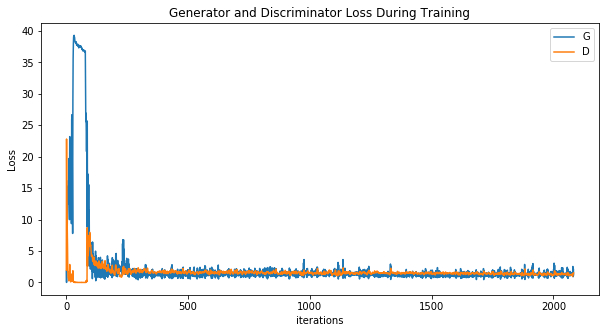

In [85]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

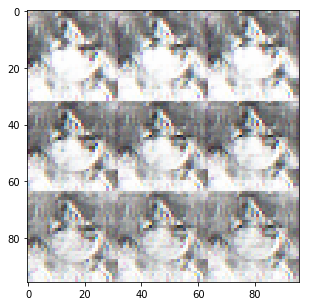

In [141]:
plt.figure(figsize=(5,5))
plt.imshow(norm01(img_list[25]))

In [113]:
final=np.reshape(img_list,(26,3,96,96))

In [169]:
image=torchvision.utils.make_grid(torch.from_numpy(final),normalize=True,nrow=5).view(590,492,3)

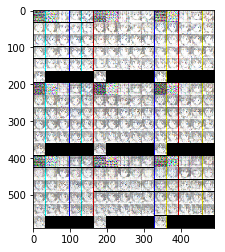

In [170]:
# plt.figure(figsize=(20,20))
plt.imshow(image.view(590,492,3))
# image.size()

In [172]:
plt.imsave(arr=image,fname='image2')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


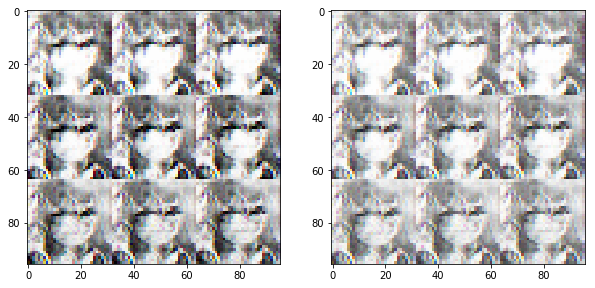

In [204]:
z=torch.randn(1,nz,1,1).to(device)
# z=torch.full((1,nz,1,1),1,device=device)
# print(z.size())
# print(z)
# z[:,15:53,:,:]=10000000
# print(z)
with torch.no_grad():
    out=netG(z)

out_im=out.view(96,96,3).cpu().numpy()
out_im_n=norm01(out_im)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(out_im)
plt.subplot(122)
plt.imshow(out_im_n)